# nmi | spring 2024
## special lecture 04 : neural networks, briefly


### lecture examples


##### code, perceptron


In [38]:
import numpy as np

class Perceptron:

  def __init__(self,learning_rate=0.01,epochs=1000,weights=None,bias=None, \
               tol=1e-8,activation_func="step",delta_func=None,leaky=0.1):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.weights = weights
    self.bias = bias
    self.tol = tol
    self.delta_func = delta_func
    self.lr_leaky = leaky

    if activation_func is None:
      activation_func = "step"
    if isinstance(activation_func,str):
      if activation_func.lower() == "relu":
        self.activation_func = self.ReLU
        self.delta_func = self.dReLU
      elif activation_func.lower() == "sigmoid":
        self.activation_func = self.sigmoid
        self.delta_func = self.dsigmoid
      elif activation_func.lower() == "tanh":
        self.activation_func = self.tanh
        self.delta_func = self.dtanh
      elif activation_func.lower()[:5] == "leaky":
        self.activation_func = self.leaky
        self.delta_func = self.dleaky
      else:
        self.activation_func = self.step
        self.delta_func = self.dstep
    else:
      self.activation_func = activation_func

  def copy(self):
    """
    Creates a copy of the Perceptron object with its own weights and bias.

    Returns:
      A new Perceptron object with the same learning rate and copied weights and bias.
    """
    perceptron_copy = Perceptron(self.learning_rate)
    perceptron_copy.epochs = np.copy(self.epochs)
    perceptron_copy.weights = np.copy(self.weights)
    perceptron_copy.bias = np.copy(self.bias)
    perceptron_copy.activation_func = np.copy(self.activation_func)
    return perceptron_copy

  def fit(self,X,y,display=False):
    n_samples,n_features = X.shape

    # init parms
    if self.weights is None or self.bias is None:
      # suggested initial weights if random
      urng_from = -1/np.sqrt(n_features)
      urng_thru = 1/np.sqrt(n_features)
      if self.weights is None:
        self.weights = np.random.uniform(urng_from,urng_thru,n_features)
      if self.bias is None:
        self.bias = np.random.uniform(urng_from,urng_thru)

    # learn
    rmse_old = self.tol*2
    for i in range(self.epochs):
      errors = 0
      for x,target in zip(X,y):
        z = np.dot(x,self.weights) + self.bias # linear_output
        y_predicted = self.activation_func(z)

        # update weights, bias
        error = y_predicted - target
        self.bias -= self.learning_rate*error
        delta = self.delta_func(x,z)
        self.weights -= self.learning_rate*error*delta*x

        errors += pow(error,2)
      rmse = np.sqrt(errors/len(y))
      if (rmse < self.tol) or (rmse == rmse_old) or (i % 100 == 0):
        if display:
          s_weights = ",".join(f"{weight:.8f}" for weight in self.weights)
          print(f"{i:6d} RMSE: {rmse:.8f}; weights: {s_weights}: bias: {self.bias:.8f}")
        if (rmse < self.tol) or (rmse == rmse_old):
          break;
      rmse_old = rmse

  def predict(self,X):
    linear_output = np.dot(X,self.weights) + self.bias
    y_predicted = self.activation_func(linear_output)
    return y_predicted

  # functions: activation, delta
  def leaky(self,x,alpha=None):
    if alpha is None:
      alpha = self.lr_leaky
    return self.sign(np.maximum(x,alpha*x))
  def dleaky(self,x,z,alpha=None):
    if alpha is None:
      alpha = self.lr_leaky
    return np.where(x>0,1,alpha)
  def ReLU(self,x):
    return self.sign(np.maximum(0,x))
  def dReLU(self,x,z):
    return np.where(x>0,1,0)
  def sigmoid(self,x):
    return np.round(1 / (1 + np.exp(-x)))
  def dsigmoid(self,x,z):
    return (1-self.sigmoid(z))*self.sigmoid(z)
  def step(self,x):
    return np.where(x > 0,1,0)
  def dstep(self,x,z):
    return 1;
  def tanh(self,x):
    return self.sign(np.tanh(x)) # (1 - np.exp(-2 * x)) / (1 + np.exp(-2 * x))
  def dtanh(self,x,z):
    return 1 - pow(self.tanh(z),2)

  # misc
  def sign(self,x):
    return x > 0



| af        | w                      |           b |   test(%) |
|-----------|------------------------|-------------|-----------|
| heaviside | 0.03237118,0.02409372  |  0.08388111 |       100 |
| sigmoid   | 0.06178258,-0.06706008 | -0.36611889 |         0 |
| ReLU      | 0.16399622,-0.02763576 | -0.14111889 |        57 |
| tanh      | 0.35208824,-0.52470878 | -0.89111889 |        33 |
| leaky     | 0.02312069,0.01358606  |  0.05888111 |       100 |


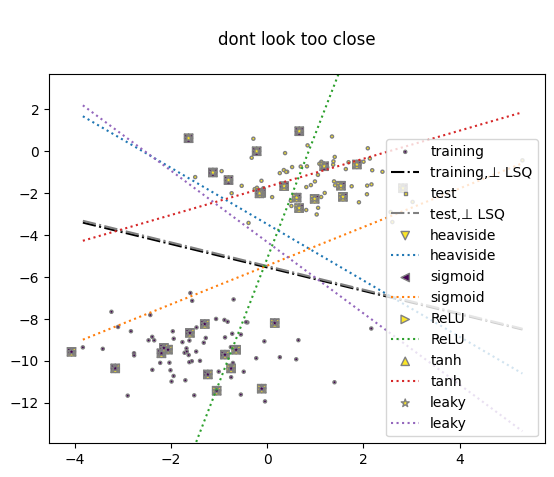

In [39]:
if __name__ == "__main__":

  # imports
  import matplotlib.pyplot as plt
  import numpy as np
  import scipy as sp
  from sklearn.model_selection import train_test_split
  from sklearn import datasets
  import statistics as st
  from tabulate import tabulate

  def accuracy(y_pred,y_true,tol=0):
    if tol == 0:
      accuracy = np.sum(y_pred==y_true) / len(y_true)
    else:
      accuracy = np.sum(abs(y_pred-y_true)<=tol) / len(y_true)
    return accuracy

  # init runtime
  debug = False

  # datasets from sklearn
  X,y = datasets.make_blobs(n_samples=150,n_features=2,centers=2,cluster_std=1.05,random_state=2)
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
  x0 = np.array([np.amin(X_train[:,0]),np.amax(X_train[:,0])]) # interval, training data

  # plot, init
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)

  if True: # plot data, training
    plt.scatter(X_train[:,0],X_train[:,1],label="training",marker="o",c=y_train,edgecolor="grey",s=5)
    # plot hyperplane, training
    slope,intercept,r,p,stde = sp.stats.linregress(X_train[:,0],X_train[:,1])
    slope = -1/slope; mid = np.mean(X_train,0); intercept = mid[1] - slope*mid[0]
    plt.plot(x0,x0*slope+intercept,label="training,⊥ LSQ",ls="-.",c="black")
    # plot data, test
    plt.scatter(X_test[:,0],X_test[:,1],label="test",marker="s",c=y_test,edgecolor="grey",s=5)
    # plot hyperplane, test
    slope,intercept,r,p,stde = sp.stats.linregress(X_test[:,0],X_test[:,1])
    slope = -1/slope; mid = np.mean(X_test,0); intercept = mid[1] - slope*mid[0]
    plt.plot(x0,x0*slope+intercept,label="test,⊥ LSQ",ls="-.",c="grey")

  # weights, bias for everyone
  n_features = X.shape[1]
  if False: # suggested weights when random
    urng_from = -1/np.sqrt(n_features)
    urng_thru = 1/np.sqrt(n_features)
  else: # suggested for ReLU
    urng_from = -0.1
    urng_thru =  0.1
  weights = np.random.uniform(urng_from,urng_thru,n_features)
  bias = np.random.uniform(urng_from,urng_thru)

  # init nn
  ss_afname = ["heaviside","sigmoid","ReLU","tanh","leaky"]
  ss_marker = ["v","<",">","^","*"] # markers for plot
  data = [] # array for tabulate

  # train and test per activation function
  for s_afname,s_marker in zip(ss_afname,ss_marker):
    p = Perceptron(learning_rate=0.005,epochs=1000,weights=weights.copy(),bias=bias,activation_func=s_afname)
    if debug: # spacer
      print(f"\n{s_afname}") # to preface displayed progress of training
    p.fit(X_train,y_train,display=debug)

    # prediction, classification
    predictions = p.predict(X_test)
    if debug: # accuracy wrt test data
      print()
      for prediction,test in zip(predictions,y_test): # look at why
        predicted = bool(accuracy(np.array([prediction]),np.array([test]),p.tol))
        if not predicted:
          print(f"{s_afname} (pred,test,match) = ({prediction:8f},{test:.0f},{predicted})")
    if debug: # accuracy wrt training data
      print()
      reruns = p.predict(X_train)
      for rerun,train in zip(reruns,y_train): # look at why
        predicted = bool(accuracy(np.array([rerun]),np.array([train]),p.tol))
        if not predicted:
          print(f"{s_afname} (rrn,train,match) = ({rerun:8f},{train:.0f},{predicted})")
      reruns = pp(reruns)
      print()
      reruns = p.predict(X_train)
      for rerun,train in zip(reruns,y_train): # look at why
        predicted = bool(accuracy(np.array([rerun]),np.array([train]),p.tol))
        if not predicted:
          print(f"{s_afname} (rrn,train,match) = ({rerun:8f},{train:.0f},{predicted})")
      reruns = np.round(reruns)

    # plot, predictions
    plt.scatter(X_test[:,0],X_test[:,1],label=s_afname,marker=s_marker,c=predictions,edgecolor="grey")

    # plot, linear separation
    x1 = -(p.weights[0]*x0+p.bias)/p.weights[1]
    ax.plot(x0,x1,label=s_afname,ls=":") # hyperplane ~ decision boundary

    # tabulate weights, bias
    s_weights = ",".join(f"{weight:.8f}" for weight in p.weights)
    s_accuracy = f"{accuracy(predictions,y_test,p.tol)*100:3.0f}"
    if debug:
      s_training = f"{accuracy(reruns,y_train,p.tol)*100:3.0f}"
      data.append([s_afname,s_weights,p.bias,s_accuracy,s_training])
    else:
      data.append([s_afname,s_weights,p.bias,s_accuracy])

  # tabulate, show
  print()
  if debug:
    print(tabulate(data,headers=["af","w","b","test(%)","trng(%)"],floatfmt=(".8f"),tablefmt="github"))
  else:
    print(tabulate(data,headers=["af","w","b","test(%)"],floatfmt=(".8f"),tablefmt="github"))

  # plot, show
  ymin = np.amin(X_train[:,1])
  ymax = np.amax(X_train[:,1])
  ax.set_ylim([ymin-2,ymax+3])
  plt.title("\ndont look too close\n")
  plt.legend(loc="lower right")
  plt.show()


###### code, tanh perceptron


[-0.00447779  0.00570092] 2.6033999007042743


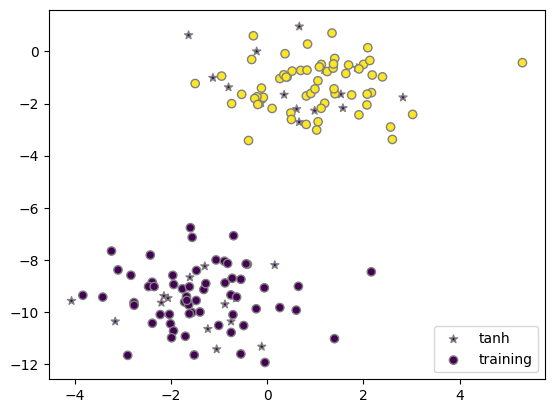

In [25]:
from sklearn.preprocessing import StandardScaler
import numpy as np

class TanhPerceptron:
  """
  A simple Tanh perceptron for binary classification with non-binary inputs.
  """

  def __init__(self, learning_rate=0.01, weights=None, bias=0):
    """
    Initialize the perceptron with learning rate, weights (optional), and bias.
    """
    self.eta = learning_rate
    self.weights = weights if weights is not None else np.random.rand(2)  # Random weights for two inputs
    self.bias = bias

  def predict(self, X):
    """
    Predict the output of the perceptron for a given input vector (two non-binary values).
    """
    z = np.dot(self.weights.T, X.T) + self.bias  # Weighted sum
    return (1 - np.exp(-2 * z)) / (1 + np.exp(-2 * z))  # Tanh activation

  def train(self, X, y, epochs=10):
    """
    Train the perceptron using gradient descent with Tanh activation.

    Args:
      X: Training data (numpy array with non-binary features for each sample).
        - Each sample should be a 1D array with two elements.
      y: Training labels (numpy array with binary labels (0 or 1) for each sample).
      epochs: Number of training epochs.
    """
    for _ in range(epochs):
      for i in range(len(X)):
        x = X[i]
        y_pred = self.predict(x)
        error = y[i] - y_pred  # Error (desired - predicted)

        # Calculate derivative of tanh (tanh') for gradient update
        tanh_derivative = 1 - y_pred**2

        # Update weights using gradient descent with tanh'
        self.weights += self.eta * tanh_derivative * x  # Element-wise multiplication
        self.bias += self.eta * tanh_derivative  # Update bias with full error

if True:
  sign = lambda x: x > 0
  # Standardize features (optional but recommended)
  scaler = StandardScaler()

  # Example usage
  perceptron = TanhPerceptron(weights=weights.copy(),bias=bias)

  # Sample training data (non-binary features and labels)
  #X = np.array([[1.0, 2.0], [0.5, 0.8], [-1.0, 0.2], [2.5, 1.0]])
  #y = np.array([1, 0, 0, 1])
  X = scaler.fit_transform(X_train)
  y = y_train

  perceptron.train(X, y, epochs=20)  # Train the perceptron
  print(perceptron.weights,perceptron.bias)

  # Test on new data
  #new_input = np.array([0.7, 1.5])
  #prediction = perceptron.predict(new_input)
  #print("Predicted output:", prediction)
  X2 = scaler.fit_transform(X_test)
  predictions = perceptron.predict(X2)
  predictions = sign(predictions)
  plt.scatter(X_test[:,0],X_test[:,1],label="tanh",marker="*",c=predictions,edgecolor="grey")
  plt.scatter(X_train[:,0],X_train[:,1],label="training",marker="o",c=y_train,edgecolor="grey")

  x0 = np.array([np.amin(X_train[:,0]),np.amax(X_train[:,0])]) # interval, training data
  x1 = -(perceptron.weights[0]*x0+perceptron.bias)/perceptron.weights[1]
  #plt.plot(x0,x1,label="tanh",ls=":") # hyperplane ~ decision boundary
  plt.legend(loc="lower right")
  plt.show()


In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TanhPerceptron(BaseEstimator, ClassifierMixin):
  """
  A custom perceptron class with Tanh activation.
  """

  def __init__(self, learning_rate=0.01, weights=None, bias=0):
    self.eta = learning_rate
    self.weights = weights if weights is not None else np.random.rand(n_features)  # Adjust n_features for your data
    self.bias = bias

  def fit(self, X, y, epochs=10):
    """
    Train the perceptron using gradient descent with Tanh activation.

    Args:
      X: Training data (numpy array with non-binary features for each sample).
        - Each sample should be a 1D array with two elements.
      y: Training labels (numpy array with binary labels (0 or 1) for each sample).
      epochs: Number of training epochs.
    """
    for _ in range(epochs):
      for i in range(len(X)):
        x = X[i]
        y_pred = self.predict(x)
        error = y[i] - y_pred  # Error (desired - predicted)

        # Calculate derivative of tanh (tanh') for gradient update
        tanh_derivative = 1 - y_pred**2

        # Update weights using gradient descent with tanh'
        self.weights += self.eta * tanh_derivative * x  # Element-wise multiplication
        self.bias += self.eta * tanh_derivative  # Update bias with full error

  def predict(self, X):
    z = np.dot(X, self.weights) + self.bias
    return (1 - np.exp(-2 * z)) / (1 + np.exp(-2 * z))  # Tanh activation

# ... (Rest of your data loading and preprocessing code)

# Create your custom Tanh perceptron
#perceptron = TanhPerceptron(learning_rate=0.01)

# Train the perceptron using your custom fit method
#perceptron.fit(X_scaled, y)  # Assuming X_scaled is your standardized data

# Evaluate accuracy
#accuracy = accuracy_score(y, perceptron.predict(X_scaled))
#print("Accuracy:", accuracy)


In [32]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Generate sample data with two features and two clusters
X, y = make_blobs(n_samples=150, n_features=2, centers=2, cluster_std=1.05, random_state=2)
X = X_train
y = y_train

# Standardize features (optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a Perceptron with a larger number of epochs and a tuned learning rate
perceptron = MLPRegressor(learning_rate=0.01)  # Adjust hyperparameters as needed

# Train the perceptron
perceptron.fit(X_scaled, y)
for i,(ws,b) in enumerate(zip(perceptron.coef_,perceptron.intercept_)):
  print(f"layer {i+1}: weights = {ws.flatten()}, bias = {b.flatten()}")

# Evaluate accuracy using sklearn metrics
from sklearn.metrics import accuracy_score
#accuracy = accuracy_score(y, perceptron.predict(X_scaled))
X_scaled2 = scaler.fit_transform(X_test)
accuracy = accuracy_score(y_test, perceptron.predict(X_scaled2))
print("Accuracy:", accuracy)


AttributeError: 'TanhPerceptron' object has no attribute 'coef_'

###### code, relu perceptron


[0.10907342 0.0856853 ] 0.3390296364015889


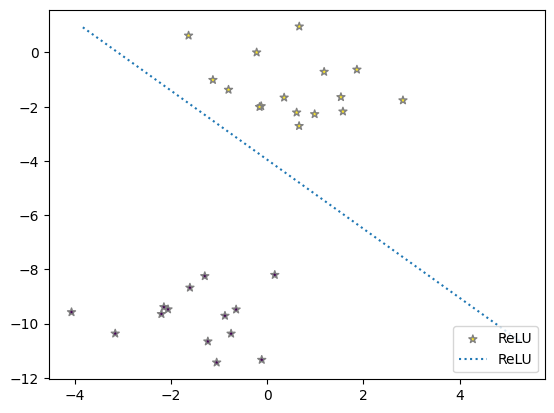

In [12]:
import matplotlib.pyplot as plt
import numpy as np

class ReLUPerceptron:
  """
  A simple ReLU perceptron for binary classification with non-binary inputs.
  """

  def __init__(self, learning_rate=0.01, weights=None, bias=0):
    """
    Initialize the perceptron with learning rate, weights (optional), and bias.
    """
    self.eta = learning_rate
    self.weights = weights if weights is not None else np.random.rand(2)  # Random weights for two inputs
    self.bias = bias

  def predict(self, X):
    """
    Predict the output of the perceptron for a given input vector (two non-binary values).
    """
    z = np.dot(self.weights.T, X.T) + self.bias  # Weighted sum
    return np.where(z > 0, 1, 0)  # ReLU activation (0 or 1)

  def train(self, X, y, epochs=10):
    """
    Train the perceptron using gradient descent with ReLU activation.

    Args:
      X: Training data (numpy array with non-binary features for each sample).
        - Each sample should be a 1D array with two elements.
      y: Training labels (numpy array with binary labels (0 or 1) for each sample).
      epochs: Number of training epochs.
    """
    for _ in range(epochs):
      for i in range(len(X)):
        x = X[i]
        y_pred = self.predict(x)
        error = y[i] - y_pred  # Error (desired - predicted)

        # Update weights using ReLU gradient (conditional based on input sign)
        self.weights += self.eta * np.where(x > 0, error * x, 0)  # Element-wise multiplication
        self.bias += self.eta * error  # Update bias with full error

if True:
  sign = lambda x: x > 0

  # Example usage
  perceptron = ReLUPerceptron(weights=weights.copy(),bias=bias)

  # Sample training data (non-binary features and labels)
  X = np.array([[1.0, 2.0], [0.5, 0.8], [-1.0, 0.2], [2.5, 1.0]])
  y = np.array([1, 0, 0, 1])
  X = X_train
  y = y_train

  perceptron.train(X, y, epochs=1000)  # Train the perceptron
  print(perceptron.weights,perceptron.bias)

  # Test on new data
  #new_input = np.array([0.7, 1.5])
  #prediction = perceptron.predict(new_input)
  #print("Predicted output:", prediction)
  predictions = perceptron.predict(X_test)
  predictions = sign(predictions)
  plt.scatter(X_test[:,0],X_test[:,1],label="ReLU",marker="*",c=predictions,edgecolor="grey")

  x0 = np.array([np.amin(X_train[:,0]),np.amax(X_train[:,0])]) # interval, training data
  x1 = -(perceptron.weights[0]*x0+perceptron.bias)/perceptron.weights[1]
  plt.plot(x0,x1,label="ReLU",ls=":") # hyperplane ~ decision boundary
  plt.legend(loc="lower right")
  plt.show()


In [4]:
if True:

  import numpy as np

  def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

  def perceptron_relu(x, w, b):
    """Perceptron with ReLU activation function"""
    activation = np.dot(x, w) + b
    return relu(activation)

  def mse_loss(y_true, y_pred):
    """Mean Squared Error loss function"""
    return np.mean((y_true - y_pred) ** 2)

  # Sample data
  #X = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 0]])
  #y_true = np.array([1, 0, 0])
  X = X_train
  y_true = y_train

  # Initialize weights and bias
  #w = np.random.rand(3)
  w = np.random.rand(2)
  b = 0

  # Learning rate
  eta = 0.1

  # Train with MSE loss
  for _ in range(100):
    for i in range(len(X)):
      y_pred = perceptron_relu(X[i], w, b)
      error = y_true[i] - y_pred
      # Gradient calculation for ReLU with respect to weighted sum (activation)
      gradient = np.where(X[i] > 0, error, 0)  # Apply error only to positive input values
      w += eta * gradient
      b += eta * error
  print(w,b)

  # Evaluate with MSE loss
  mse_loss_after_training = mse_loss(y_true, np.array([perceptron_relu(x, w, b) for x in X]))
  print("MSE loss after training with ReLU:", mse_loss_after_training)


[0.16509962 0.05258499] 0.8202475585901758
MSE loss after training with ReLU: 0.04217930417574995


### the labs


### lab one. vanilla perceptron.


code a **vanilla** perceptron. use numpy, matplotlib (to display output), sklearn (to partition data).
</br></br>

1. code as python class.
2. include parameters for learning rate, epochs.
3. include attributes for weights, bias.
4. include method "\_\_init\_\_".
5. include method for training. (use sigmoid for activation function.)
6. include method for prediction.
7. use an instance of your class against provided sklearn dataset.
</br>

<font color=red>this is the response for <b>final q21</b>.</font>
</br>


###### code


In [ ]:
# exact usage of sklearn for this problem

from sklearn.model_selection import train_test_split
from sklearn import datasets

# datasets from sklearn
X,y = datasets.make_blobs(n_samples=150,n_features=2,centers=2,cluster_std=1.05,random_state=2)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)


In [ ]:
# your class here


In [ ]:
# your instance here


### lab two. XOR MLP.


###### code, prep

In [ ]:
# lies lies lies
!pip install -U scikit-learn
# lies lies lies


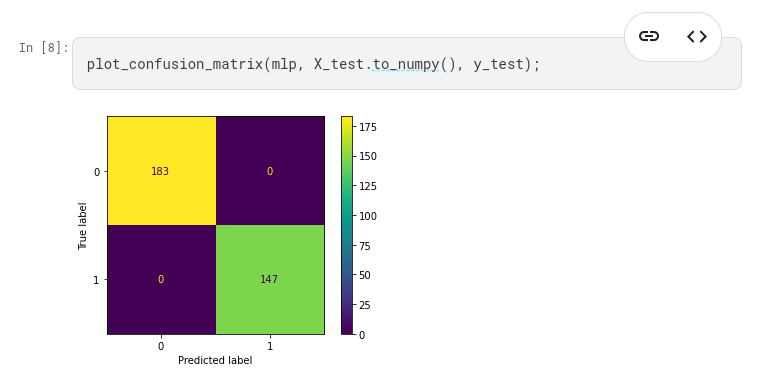

In [ ]:
# google drive stuff
google_drive = "/content/drive/My Drive/Colab Notebooks/" # colab home directory
local = "" # if subdirectory; eg, "test/" # yes, "/" is important
path = google_drive + local

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###### code, xor with mlp


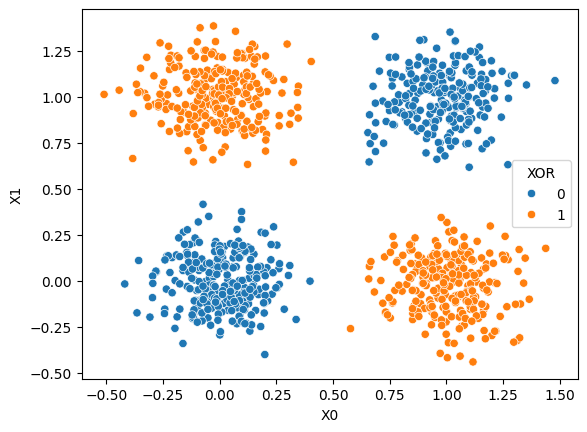

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

file = "kaggle/input/noisy-xor/XOR.csv" # file in that local path
df = pd.read_csv(path+file) # csv file read into pandas.dataframe

sns.scatterplot(x = df['X0'],y = df['X1'],hue = df['XOR']);


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


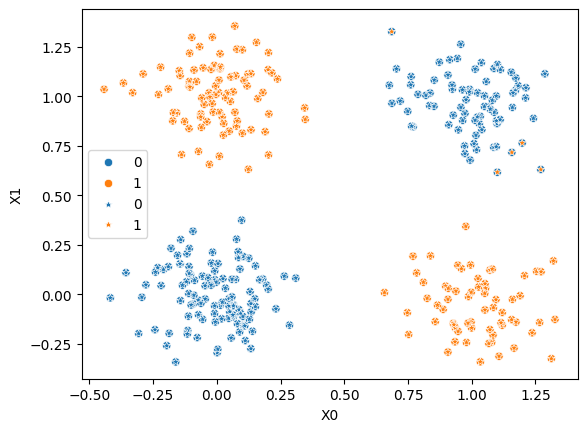

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
#from sklearn.metrics import plot_confusion_matrix

mlp = MLPClassifier(hidden_layer_sizes=[8])

X = df[['X0','X1']]
y = df['XOR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mlp.fit(X_train,y_train)
#plot_confusion_matrix(mlp,X_test.to_numpy(),y_test); # more lies!

y_mlp = mlp.predict(X_test)
sns.scatterplot(x = X_test['X0'],y = X_test['X1'],hue = y_test);
sns.scatterplot(x = X_test['X0'],y = X_test['X1'],hue = y_mlp,marker="*");


* MLPClassifier [@sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)


layer 1: weights = [5.69588103 5.7085265 ], bias = [-9.01497297]
layer 2: weights = [-8.553099], bias = [0.69240701]

predicted label for [1 0]: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


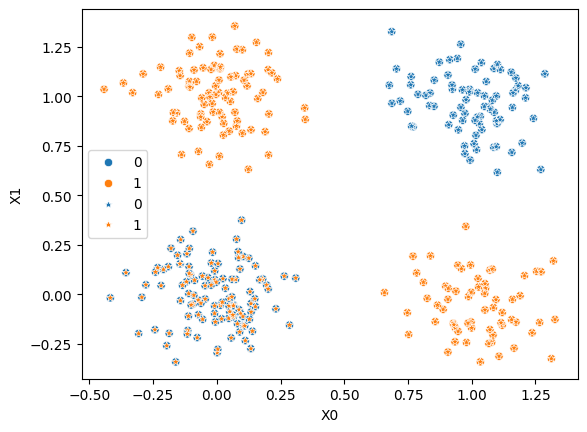

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Define the XOR data
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
y = [0, 1, 1, 0]

# Standardize the data (optional but can help with convergence)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the MLP model
model = MLPClassifier(solver='lbfgs',activation='logistic',hidden_layer_sizes=(1,),random_state=1)

# Train the model on the XOR data
model.fit(X_scaled, y)

# Access weights (coefs_)
hidden_weights = model.coefs_
for i,(ws,b) in enumerate(zip(model.coefs_,model.intercepts_)):
  print(f"layer {i+1}: weights = {ws.flatten()}, bias = {b.flatten()}")

# Make predictions for unseen data
new_data = [[1, 0]]  # Try a new input point
new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)

print(f"\npredicted label for {np.array(new_data).flatten()}:", bool(prediction[0]))

y_mlp = model.predict(scaler.transform(X_test))
sns.scatterplot(x = X_test['X0'],y = X_test['X1'],hue = y_test);
sns.scatterplot(x = X_test['X0'],y = X_test['X1'],hue = y_mlp,marker="*");


lies